# Imports

In [53]:
# data collection and manipulation
import datetime as dt
import pandas as pd
import numpy as np
from math import ceil, floor
import random
import yfinance as yf
from yahoo_fin import stock_info as si
# matplotlib
import scienceplots
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = 'Open Sans'
plt.style.use(['science', 'notebook', 'grid'])
# ML
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout
# full-screen notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data import

In [2]:
# start date (year, month, day)
y_start = 2018
m_start = 1
d_start = 1

# end date (if any of those are 0, will default to the current date)
y_end = 0
m_end = 0
d_end = 0

# time interval, possible values: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
interval = '1d'

# all tickers traded on NASDAQ Exchange
def nasdaq_tickers():
    return si.tickers_nasdaq()

# sample n random tickers from a list
def random_tickers(tickers, n = 10, seed = -1):
    if seed > 0:
        random.seed(seed, version = 2)
        np.random.seed(seed)
    return pd.DataFrame(tickers, columns = ['ticker']).sample(n, replace = False)['ticker'].values.tolist()

# get info (default is Adj Close price) for a list of tickers
def get_stocks(indices, interval, y_start, m_start, d_start, y_end = 0, m_end = 0, d_end = 0, column = 'Adj Close'):
    if y_end == 0 or m_end == 0 or d_end == 0: end = dt.date.today()
    else: end = dt.datetime(y_end, m_end, d_end, 0, 0)
    df = yf.download(indices, interval = interval, start = dt.datetime(y_start, m_start, d_start, 0, 0), end = end, progress = False)[column]
    df.dropna(axis = 0, how = 'all', inplace = True)
    return df

# deletes tickers from a list if these is not enough data for analysis
def ticker_cleaner(tickers, interval, y_start, m_start, d_start, y_end = 0, m_end = 0, d_end = 0):
    stocklist = get_stocks(tickers, interval, y_start, m_start, d_start, y_end, m_end, d_end)[1]
    benchmark = stocklist['count'].max()
    for i in stocklist.T.columns:
        if stocklist.T[i].T['count'] < benchmark:
            tickers.remove(i)
    return tickers

In [ ]:
ticker_list = ticker_cleaner(nasdaq_tickers(), interval, y_start, m_start, d_start)

In [ ]:
tickers = random_tickers(ticekr_list, n = 10, seed = 1)
stocklist = get_stocks(tickers, interval, y_start, m_start, d_start)

In [15]:
stocklist

,AEIS,AFBI,EAST,MAT,MNDO,MSBI,NWFL,PNQI,PSC,UAL
Date,,,,,,,,,,
2018-01-02,69.274063,11.730,78.000000,16.020000,1.766587,27.895523,28.622837,118.239998,29.828785,68.940002
2018-01-03,68.785027,11.790,79.800003,16.139999,1.747315,27.947067,28.275684,119.839996,29.833553,68.489998
2018-01-04,67.826897,11.800,77.400002,15.910000,1.760163,28.136076,27.867777,119.820000,29.833553,69.260002
2018-01-05,71.709274,11.700,80.000000,16.260000,1.740891,28.264944,27.390438,121.550003,29.833553,69.360001
2018-01-08,71.499687,11.570,78.419998,15.810000,1.734467,28.144663,27.694199,122.839996,30.079666,68.510002
...,...,...,...,...,...,...,...,...,...,...
2023-06-26,105.239998,12.100,3.130000,18.139999,1.960000,20.059999,30.469999,152.750000,40.900002,53.320000
2023-06-27,108.570000,12.005,3.130000,18.450001,1.960000,19.870001,29.620001,155.179993,41.540001,56.029999
2023-06-28,109.000000,11.830,3.160000,18.980000,1.960000,19.969999,28.680000,155.949997,41.700001,56.299999


# Sample creation and preprocessing

In [42]:
# will output 3 subsamples: the training (default is 80% of the sample), test (default is 20% of the sample) and validation subsamples
def create_subsamples(df, train_ratio = 0.8, validation_ratio = 0):
    train_sample = pd.DataFrame(df[0:ceil(len(df)*train_ratio)])
    test_sample = pd.DataFrame(df[ceil(len(df)*train_ratio):len(df) - floor(len(df)*validation_ratio)])
    validation_sample = pd.DataFrame(df[len(df) - floor(len(df)*validation_ratio):len(df)])
    return train_sample, test_sample, validation_sample

# comutes a mean squared error between two df's
def MSE(df, df_hat):
    return np.square(np.subtract(np.array(df), np.array(df_hat))).mean()

# comutes a mean absolute % error between two df's
def MAPE(df, df_hat):
    return (np.abs(np.subtract(np.array(df), np.array(df_hat)))/np.array(df)).mean()

# scales the data using minmaxscaler
def preprocessing(tickers, stocklist, train_ratio = 0.8, validation_ratio = 0):
    transform_train = {}
    transform_test = {}
    scaler = {}
    df_ = {}
    for i in tickers:
        df_[i] = {}
        df_[i]['Train'], df_[i]['Test'] = create_subsamples(stocklist[i], train_ratio, validation_ratio)[0], create_subsamples(stocklist[i], train_ratio, validation_ratio)[1]
    for num, i in enumerate(tickers):
        sc = MinMaxScaler(feature_range=(0, 1))
        a0 = np.array(df_[i]['Train'])
        a1 = np.array(df_[i]['Test'])
        a0 = a0.reshape(a0.shape[0], 1)
        a1 = a1.reshape(a1.shape[0], 1)
        transform_train[i] = sc.fit_transform(a0)
        transform_test[i] = sc.fit_transform(a1)
        scaler[i] = sc
    return transform_train, transform_test, scaler

# does a train-test split
def train_test(stocklist, tickers, transform_train, transform_test, periods_back = 60, train_ratio = 0.8, validation_ratio = 0, H = 1):
    train_size, test_size = create_subsamples(stocklist, train_ratio, validation_ratio)[0].shape[0], create_subsamples(stocklist, train_ratio, validation_ratio)[1].shape[0]
    trainset = {}
    testset = {}
    for j in tickers:
        trainset[j] = {}
        X_train, y_train = [], []
        for i in range(periods_back, train_size - H + 1):
            X_train.append(transform_train[j][i - periods_back : i, 0])
            y_train.append(transform_train[j][i : i + H, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]['X'] = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        trainset[j]['y'] = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

        testset[j] = {}
        X_test, y_test = [], []
        for i in range(periods_back, test_size - H + 1):
            X_test.append(transform_test[j][i - periods_back : i, 0])
            y_test.append(transform_test[j][i : i + H, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]['X'] = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        testset[j]['y'] = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
    return trainset, testset, X_train

# LSTM model

In [57]:
def LSTM_model(stocklist, tickers, trainset, transform_train, testset, transform_test,
               neurons = 100, epochs = 5, batch_size = 1, dropout = 0, periods_back = 60,
               train_ratio = 0.8, validation_ratio = 0, H = 1):
    X_train = train_test(stocklist, tickers, transform_train, transform_test, periods_back, train_ratio, validation_ratio)[2]
    model = Sequential()
    model.add(LSTM(neurons, return_sequences = True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences = True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences = False))
    model.add(Dropout(dropout))
    model.add(Dense(units = 25*H))
    model.add(Dense(units = H))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    for i in tickers:
        model.fit(trainset[i]['X'], trainset[i]['y'], epochs, batch_size, verbose = 0)
    return model

def predictions_LSTM(tickers, scaler, model, testset, stocklist, train_ratio = 0.8, validation_ratio = 0, plots = False, loc = 'lower left', figsize = (30, 40), size = 30):
    pred_result = pd.DataFrame(columns = tickers)
    if plots:
        fig, axes = plt.subplots(ceil(len(tickers)/2), 2, figsize = figsize)
        plt.rcParams['font.family'] = 'Open Sans'
    j = 0
    k = 0
    for i in tickers:
        y_true = scaler[i].inverse_transform(testset[i]['y'].reshape(-1,1))
        y_pred = scaler[i].inverse_transform(model.predict(testset[i]['X'], verbose = 0))
        pred_result[i] = pd.DataFrame(y_pred)
        y_true = pd.DataFrame(y_true).set_index(stocklist.tail(pred_result.shape[0]).index).head(pd.DataFrame(y_true).set_index(stocklist.tail(pred_result.shape[0]).index).shape[0]-1)
        y_pred = pd.DataFrame(y_pred).set_index(stocklist.tail(pred_result.shape[0]).index).shift(-1).head(pd.DataFrame(y_pred).set_index(stocklist.tail(pred_result.shape[0]).index).shape[0]-1)
        if plots:
            ax = axes[k][j%2]
            ax.set_xlabel('Date [yyyy-mm-dd]')
            ax.set_ylabel('Adjusted close price [USD]')
            ax.set_title(f'{i} ticker LSTM model prediction on test data. RMSE ≈ {round(MSE(y_pred, y_true)**(1/2), 4)}; MAPE ≈ {round(MAPE(y_pred, y_true)*100, 2)}%', fontsize = 24)
            ax.plot(y_pred, color = 'red', label = 'Prediction')
            ax.plot(y_true, color = 'blue', label = 'Actual')
        j += 1
        if j%2 == 0: k += 1
    pred_result = pred_result.set_index(stocklist.tail(pred_result.shape[0]).index)
    if not plots:
        return pred_result
    else:
        if not len(tickers)%2 == 0:
            ax = axes[ceil(len(tickers)/2) - 1][1]
            ax.set_visible(False)
        ax = axes[0][0]
        ax.legend(loc = loc, fancybox = False, edgecolor = 'black', fontsize = size*0.75)
        plt.xticks(rotation = 0)
        params = {'axes.labelsize': size,
                  'axes.titlesize': size,
                  'xtick.labelsize': size*0.65,
                  'ytick.labelsize': size*0.75,
                  'axes.titlepad': 25}
        plt.rcParams.update(params)
        plt.tight_layout()
        plt.show()

# Model inputs

In [28]:
train_ratio = 0.8
validation_ratio = 0
transform_train = preprocessing(tickers, stocklist, train_ratio, validation_ratio)[0]
transform_test = preprocessing(tickers, stocklist, train_ratio, validation_ratio)[1]
scaler = preprocessing(tickers, stocklist, train_ratio, validation_ratio)[2]
H = 1
periods_back = 60
trainset = train_test(stocklist, tickers, transform_train, transform_test, periods_back, train_ratio, validation_ratio, H)[0]
testset = train_test(stocklist, tickers, transform_train, transform_test, periods_back, train_ratio, validation_ratio, H)[1]
neurons = 120
epochs = 50
batch_size = 5
dropout = 0
model = LSTM_model(stocklist, tickers, trainset, transform_train, testset, transform_test, neurons, epochs, batch_size, dropout, periods_back, train_ratio, validation_ratio, H)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 120)           58560     
                                                                 
 dropout_6 (Dropout)         (None, 60, 120)           0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 120)           115680    
                                                                 
 dropout_7 (Dropout)         (None, 60, 120)           0         
                                                                 
 lstm_8 (LSTM)               (None, 120)               115680    
                                                                 
 dropout_8 (Dropout)         (None, 120)               0         
                                                                 
 dense_4 (Dense)             (None, 25)               

# Predictions

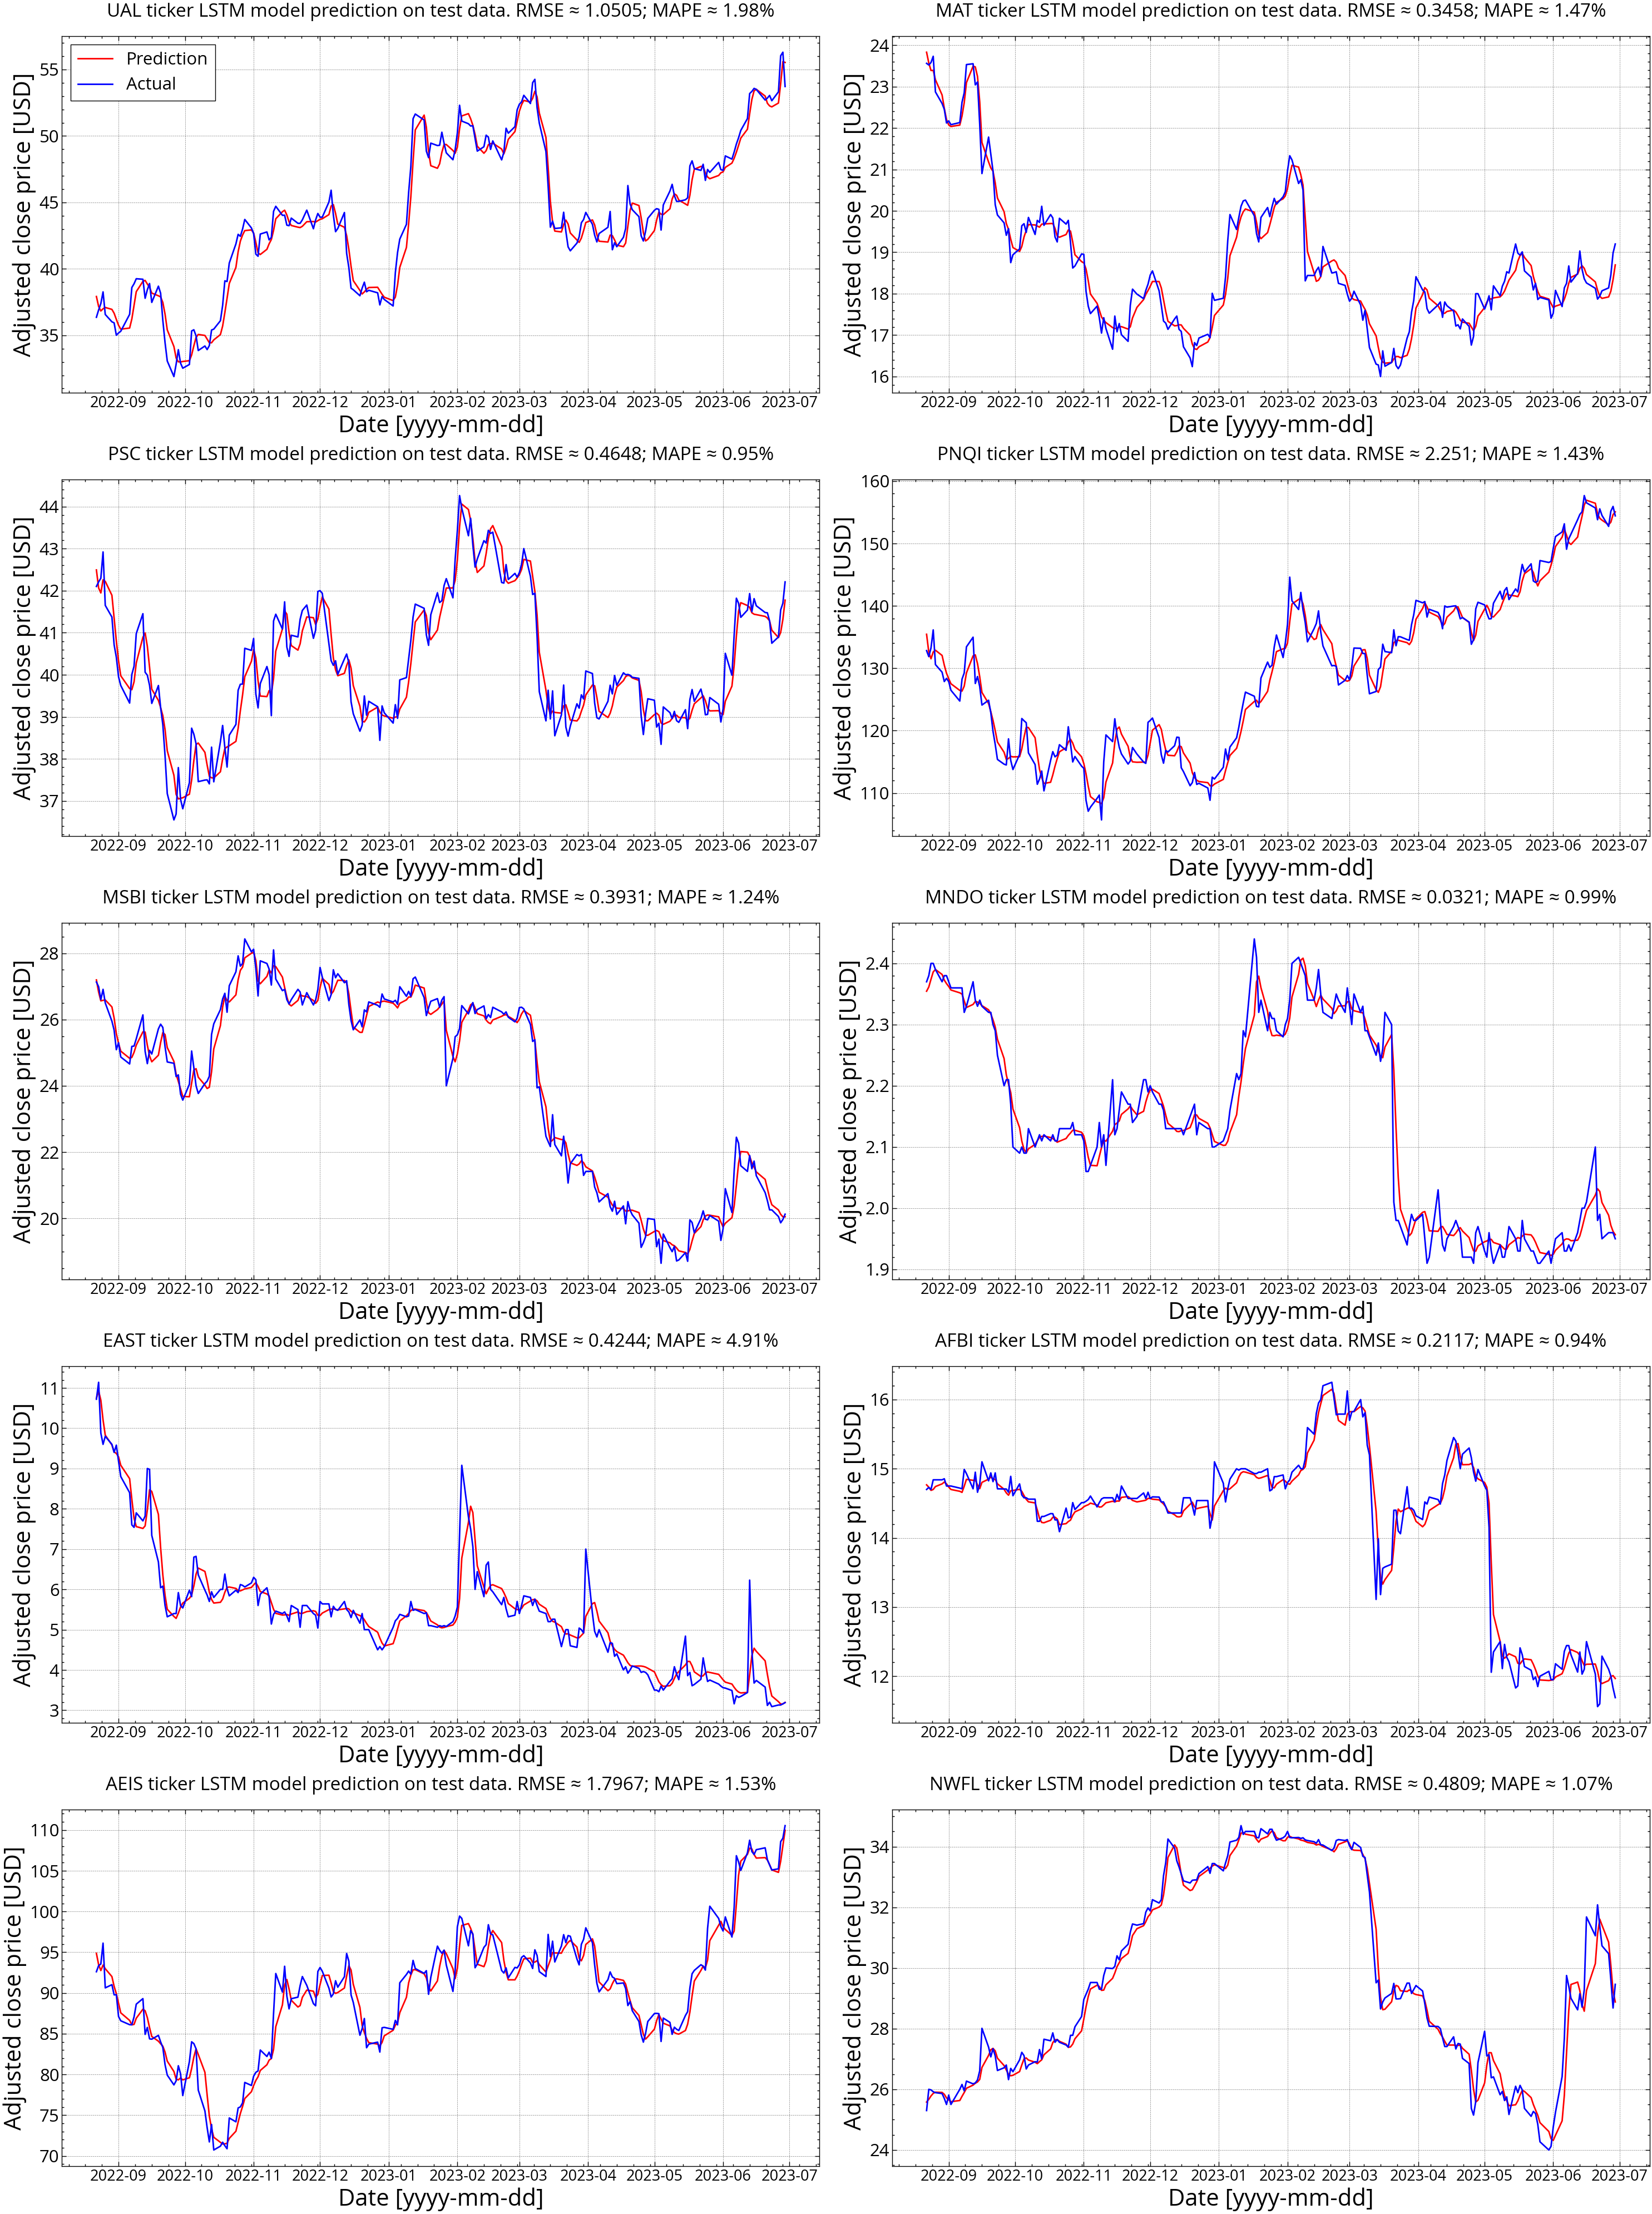

In [59]:
predictions_LSTM(tickers, scaler, model, testset, stocklist, train_ratio, validation_ratio, plots = True, loc = 'upper left', size = 30, figsize = (30, 40))